# High Order Fuzzy Time Series 

Severiano, S. A. Jr; Silva, P. C. L.; Sadaei, H. J.; Guimarães, F. G. Very Short-term Solar Forecasting using Fuzzy Time Series. 2017 IEEE International Conference on Fuzzy Systems. DOI10.1109/FUZZ-IEEE.2017.8015732

# Common Imports

In [1]:
import matplotlib.pylab as plt
from pyFTS.benchmarks import benchmarks as bchmk
from pyFTS.models import hofts

from pyFTS.common import Transformations
tdiff = Transformations.Differential(1)

%pylab inline

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Data Loading

In [4]:
#from pyFTS.data import Enrollments

#enrollments = Enrollments.get_data()

import pandas as pd
import numpy as np
import os
import pkg_resources
from pathlib import Path
from urllib import request



/home/petronio/dados/Dropbox/Doutorado/Codigos/pyFTSsource/pyFTS/notebooks/teste


# Exploring the partitioning effects on original data

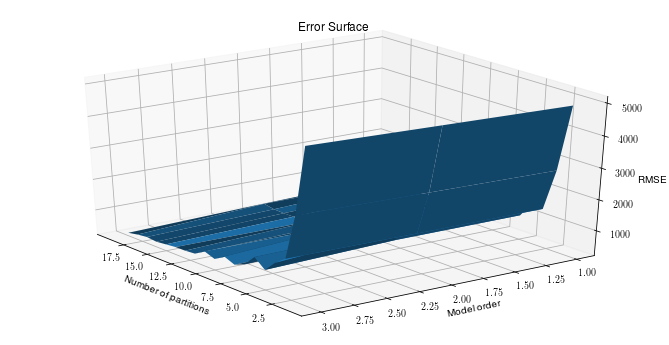

In [6]:
tmp = bchmk.simpleSearch_RMSE(enrollments, enrollments, hofts.HighOrderFTS, range(1,20), [1, 2, 3], tam=[10, 5])

# Exploring the partitioning effects on transformed data

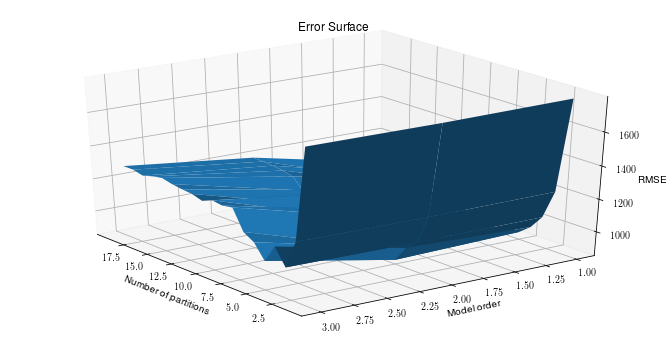

In [7]:
tmp = bchmk.simpleSearch_RMSE(enrollments, enrollments, hofts.HighOrderFTS, range(1,20), [1, 2, 3], 
                              transformation=tdiff, tam=[10, 5])

# Comparing the partitioning schemas

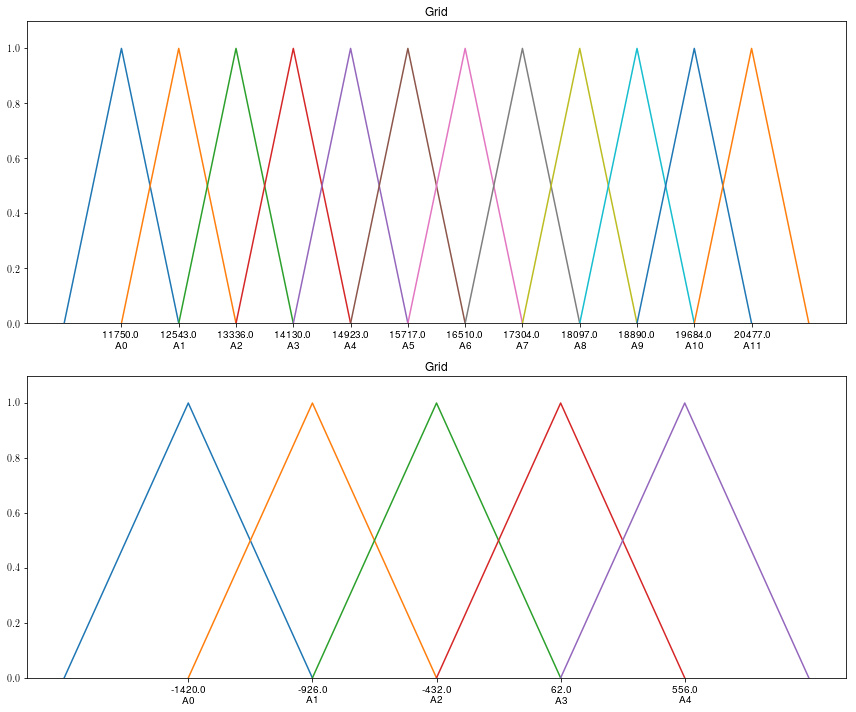

In [8]:
from pyFTS.partitioners import Grid, Util as pUtil

fuzzy_sets = Grid.GridPartitioner(data=enrollments, npart=12)
fuzzy_sets2 = Grid.GridPartitioner(data=enrollments, npart=5, transformation=tdiff)

pUtil.plot_partitioners(enrollments, [fuzzy_sets,fuzzy_sets2])

# Fitting a model on original data

In [9]:
model1 = hofts.HighOrderFTS("FTS", partitioner=fuzzy_sets)
model1.fit(enrollments, order=3)

print(model1)

[ 17:43:07] Start training
[ 17:43:07] Finish training
High Order FTS:
A1,A2,A2 -> A3,A4
A1,A2,A3 -> A3,A4
A1,A3,A2 -> A3,A4
A1,A3,A3 -> A3,A4
A10,A10,A10 -> A8,A9
A10,A10,A9 -> A8,A9
A10,A9,A10 -> A8,A9
A10,A9,A9 -> A8,A9
A2,A2,A2 -> A3,A4
A2,A2,A3 -> A3,A4,A5
A2,A2,A4 -> A4,A5
A2,A3,A2 -> A3,A4
A2,A3,A3 -> A3,A4,A5
A2,A3,A4 -> A4,A5
A2,A3,A5 -> A4,A5
A2,A4,A4 -> A4,A5
A2,A4,A5 -> A4,A5
A3,A2,A3 -> A4,A5
A3,A2,A4 -> A4,A5
A3,A3,A3 -> A4,A5
A3,A3,A4 -> A4,A5
A3,A3,A5 -> A4,A5
A3,A4,A4 -> A4,A5
A3,A4,A5 -> A4,A5
A3,A5,A4 -> A4,A5
A3,A5,A5 -> A4,A5
A4,A4,A4 -> A4,A5,A6
A4,A4,A5 -> A4,A5,A6,A7
A4,A4,A6 -> A6,A7
A4,A5,A4 -> A4,A5,A6
A4,A5,A5 -> A4,A5,A6,A7
A4,A5,A6 -> A6,A7,A8,A9
A4,A5,A7 -> A6,A7,A8,A9
A4,A6,A6 -> A6,A7,A8,A9
A4,A6,A7 -> A6,A7,A8,A9
A5,A4,A4 -> A4,A5,A6
A5,A4,A5 -> A4,A5,A6,A7
A5,A4,A6 -> A6,A7
A5,A5,A4 -> A4,A5,A6
A5,A5,A5 -> A4,A5,A6,A7
A5,A5,A6 -> A6,A7,A8,A9
A5,A5,A7 -> A6,A7,A8,A9
A5,A6,A6 -> A5,A6,A7,A8,A9
A5,A6,A7 -> A5,A6,A7,A8,A9
A5,A6,A8 -> A10,A9
A5,A6,A9 -> A1

# Fitting a model on transformed data

In [10]:
model2 = hofts.HighOrderFTS("FTS Diff", partitioner=fuzzy_sets2)
model2.append_transformation(tdiff)
model2.fit(enrollments, order=3)

print(model2)

[ 17:43:16] Start training
[ 17:43:16] Finish training
High Order FTS:
A0,A1,A2 -> A2,A3
A0,A1,A3 -> A2,A3
A0,A2,A2 -> A2,A3
A0,A2,A3 -> A2,A3,A4
A0,A2,A4 -> A4
A0,A3,A3 -> A4
A0,A3,A4 -> A4
A1,A0,A1 -> A2,A3
A1,A0,A2 -> A2,A3
A1,A1,A0 -> A1,A2
A1,A1,A1 -> A1,A2,A3
A1,A1,A2 -> A2,A3
A1,A1,A3 -> A2,A3
A1,A1,A4 -> A2,A3
A1,A2,A0 -> A1,A2
A1,A2,A1 -> A1,A2
A1,A2,A2 -> A1,A2,A3,A4
A1,A2,A3 -> A2,A3,A4
A1,A2,A4 -> A2,A3,A4
A1,A3,A1 -> A1,A2
A1,A3,A2 -> A1,A2,A3,A4
A1,A3,A3 -> A2,A3,A4
A1,A3,A4 -> A4
A1,A4,A2 -> A2,A3
A1,A4,A3 -> A2,A3
A2,A0,A1 -> A2,A3
A2,A0,A2 -> A2,A3,A4
A2,A0,A3 -> A3,A4
A2,A1,A0 -> A1,A2
A2,A1,A1 -> A0,A1,A2,A3,A4
A2,A1,A2 -> A0,A1,A2,A3,A4
A2,A1,A3 -> A1,A2,A3,A4
A2,A1,A4 -> A2,A3
A2,A2,A0 -> A1,A2,A3
A2,A2,A1 -> A0,A1,A2,A3,A4
A2,A2,A2 -> A0,A1,A2,A3,A4
A2,A2,A3 -> A1,A2,A3,A4
A2,A2,A4 -> A2,A3
A2,A3,A0 -> A2,A3
A2,A3,A1 -> A1,A2,A3
A2,A3,A2 -> A1,A2,A3,A4
A2,A3,A3 -> A1,A2,A3,A4
A2,A3,A4 -> A2,A3
A2,A4,A2 -> A1,A2,A3
A2,A4,A3 -> A1,A2,A3
A2,A4,A4 -> A2,A3
A3,A0,A2 ->

# Using the models

In [11]:
model1.predict(enrollments)

[14923.233333333337,
 15319.950000000004,
 15319.950000000004,
 16113.383333333339,
 16113.383333333339,
 17700.250000000007,
 17303.53333333334,
 16113.383333333339,
 15319.950000000004,
 15319.950000000004,
 15319.950000000004,
 16113.383333333339,
 16113.383333333339,
 17700.250000000007,
 17303.53333333334,
 19287.116666666676,
 19287.116666666676,
 18890.40000000001,
 18890.40000000001,
 18890.40000000001]

In [12]:
model2.predict(enrollments)

[12941.02,
 14511.2,
 15028.14,
 15126.2,
 15171.14,
 15182.08,
 16375.14,
 16734.2,
 16944.38,
 15248.2,
 15806.32,
 14960.2,
 14978.2,
 15058.02,
 16427.14,
 17718.14,
 18538.14,
 19390.260000000002,
 19152.2,
 18691.2]

# Comparing the models

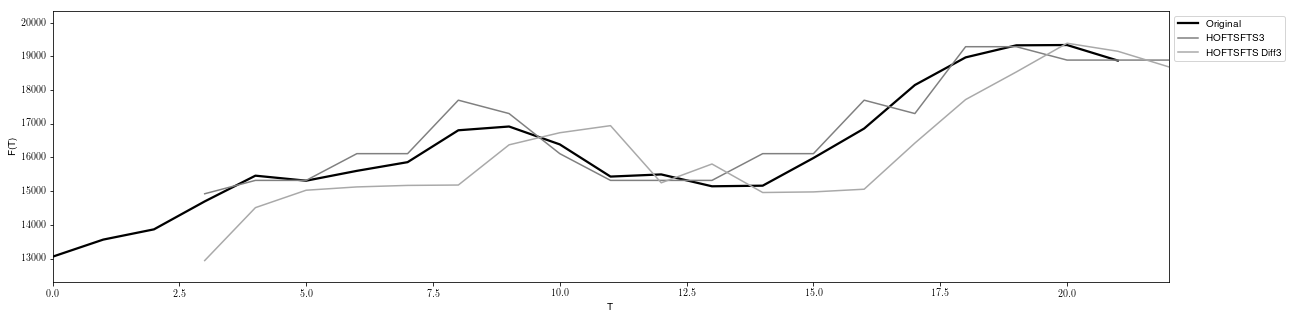

In [13]:
bchmk.plot_compared_series(enrollments, [model1, model2], bchmk.colors, intervals=False)

In [14]:
bchmk.print_point_statistics(enrollments, [model1, model2])

Model		& Order     & RMSE		& SMAPE      & Theil's U		\\ 
HOFTSFTS		& 3		& 466.65		& 1.06		& 0.76	\\ 
HOFTSFTS Diff		& 3		& 1029.5		& 2.66		& 1.68	\\ 



# Residual Analysis

In [ ]:
from pyFTS.benchmarks import ResidualAnalysis as ra

ra.plot_residuals(enrollments, [model1, model2])